## Q.71. マスキング

*imori.jpg*に対してHSVを用いて青色の箇所のみが黒くなるようにマスキングせよ。

このように白黒のバイナリ画像を用いて黒部分に対応する元画像の画素を黒に変更する操作をマスキングという。

青色箇所の抽出はHSVで180<=H<=260となる位置が1となるような二値画像を作成し、それの0と1を反転したものと元画像との積をとればよい。

これによりある程度のイモリの部分の抽出ができる。

|入力 (imori.jpg) |マスク(answers/answer_70.png)|出力(answers/answer_71.jpg)|
|:---:|:---:|:---:|
|![](imori.jpg)|![](answers/answer_70.png)|![](answers/answer_71.jpg)|

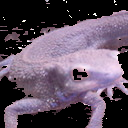

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Read image
img = cv2.imread("imori.jpg").astype(np.float32) / 255.

# RGB > HSV

max_v = np.max(img, axis=2).copy()
min_v = np.min(img, axis=2).copy()
min_arg = np.argmin(img, axis=2)

H = np.zeros_like(max_v)

H[np.where(max_v == min_v)] = 0
## if min == B
ind = np.where(min_arg == 0)
H[ind] = 60 * (img[..., 1][ind] - img[..., 2][ind]) / (max_v[ind] - min_v[ind]) + 60
## if min == R
ind = np.where(min_arg == 2)
H[ind] = 60 * (img[..., 0][ind] - img[..., 1][ind]) / (max_v[ind] - min_v[ind]) + 180
## if min == G
ind = np.where(min_arg == 1)
H[ind] = 60 * (img[..., 2][ind] - img[..., 0][ind]) / (max_v[ind] - min_v[ind]) + 300
    
V = max_v.copy()
S = max_v.copy() - min_v.copy()

# color tracking
mask = np.zeros_like(H)
mask[np.where((H>180) & (H<260))] = 1

# masking
mask = 1 - mask
out = img.copy() * 255.

for c in range(3):
    out[..., c] *= mask

out = out.astype(np.uint8)
display(Image.fromarray(out))

## Q.72. マスキング(カラートラッキング＋モルフォロジー)

Q.71ではマスクが雑になってしまっていたので、イモリの目の部分が削除されていたり、背景がところどころ残ってしまった。

よってマスク画像にN=5のクロージング処理(Q.50)とオープニング処理(Q.49)を施してマスク画像を正確にして、マスキングを行え。

|入力 (imori.jpg) |マスク(answers/answer_72_mask.png)|出力(answers/answer_72.jpg)|
|:---:|:---:|:---:|
|![](imori.jpg)|![](answers/answer_72_mask.png)|![](answers/answer_72.jpg)|

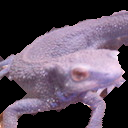

In [2]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32) / 255.

# RGB > HSV

max_v = np.max(img, axis=2).copy()
min_v = np.min(img, axis=2).copy()
min_arg = np.argmin(img, axis=2)

H = np.zeros_like(max_v)

H[np.where(max_v == min_v)] = 0
## if min == B
ind = np.where(min_arg == 0)
H[ind] = 60 * (img[..., 1][ind] - img[..., 2][ind]) / (max_v[ind] - min_v[ind]) + 60
## if min == R
ind = np.where(min_arg == 2)
H[ind] = 60 * (img[..., 0][ind] - img[..., 1][ind]) / (max_v[ind] - min_v[ind]) + 180
## if min == G
ind = np.where(min_arg == 1)
H[ind] = 60 * (img[..., 2][ind] - img[..., 0][ind]) / (max_v[ind] - min_v[ind]) + 300
    
V = max_v.copy()
S = max_v.copy() - min_v.copy()

# color tracking
mask = np.zeros_like(H)
mask[np.where((H>180) & (H<260))] = 255

h, w, _ = img.shape

# Closing
## Morphology filter
MF = np.array(((0, 1, 0),
               (1, 0, 1),
               (0, 1, 0)), dtype=int)

## Morphology - dilate
Dil_time = 5

for i in range(Dil_time):
    tmp = np.pad(mask, (1, 1), 'edge')
    for y in range(1, h+1):
        for x in range(1, w+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) >= 255:
                mask[y-1, x-1] = 255
## Morphology - erode
Erode_time = 5

for i in range(Erode_time):
    tmp = np.pad(mask, (1, 1), 'edge')
    for y in range(1, h+1):
        for x in range(1, w+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) < 255*4:
                mask[y-1, x-1] = 0

# Opening
## Morphology - erode
Erode_time = 5

for i in range(Erode_time):
    tmp = np.pad(mask, (1, 1), 'edge')
    for y in range(1, h+1):
        for x in range(1, w+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) < 255*4:
                mask[y-1, x-1] = 0

## Morphology - dilate
Dil_time = 5

for i in range(Dil_time):
    tmp = np.pad(mask, (1, 1), 'edge')
    for y in range(1, h+1):
        for x in range(1, w+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) >= 255:
                mask[y-1, x-1] = 255

# masking
cv2.imwrite("out_mask.png", mask.astype(np.uint8))

mask = 1 - mask / 255
out = img.copy() * 255.

for c in range(3):
    out[..., c] *= mask

out = out.astype(np.uint8)
display(Image.fromarray(out))

## Q.73. 縮小と拡大

*imori.jpg*をグレースケールにしたものを0.5倍に縮小した後に2倍に拡大した画像を求めよ。
この処理を行うと、ぼやけた画像ができる。

拡大縮小にはbi-linear補間を用いよ。bi-linear補間をメソッド（関数）化すると、プログラムが簡潔にできる。

|入力 (imori.jpg) |出力(answers/answer_73.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers/answer_73.jpg)|

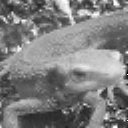

In [3]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

def resize(img, a):
    _h, _w  = img.shape
    h = int(a * _h)
    w = int(a * _w)
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / a)
    x = (x / a)

    ix = np.floor(x).astype(int)
    iy = np.floor(y).astype(int)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _w-2)

    dx = x - ix
    dy = y - iy
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out

p = resize(gray, 0.5)
p = resize(p, 2.)

out = p.astype(np.uint8)
display(Image.fromarray(out))

## Q.74. ピラミッド差分による高周波成分の抽出

Q.73で求めた画像と元画像の差分を求め、[0,255]に正規化せよ。

ここで求めた画像はエッジとなっている。つまり、画像中の高周波成分をとったことになる。

|入力 (imori.jpg) |出力(answers/answer_74.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers/answer_74.jpg)|

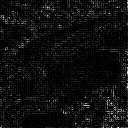

In [4]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

def resize(img, a):
    _h, _w  = img.shape
    h = int(a * _h)
    w = int(a * _w)

    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / a)
    x = (x / a)

    ix = np.floor(x).astype(int)
    iy = np.floor(y).astype(int)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _w-2)

    dx = x - ix
    dy = y - iy
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out

p = resize(gray, 0.5)
p = resize(p, 2.)

out = np.abs(gray - p)

out = out / out.max() * 255

out = out.astype(np.uint8)
display(Image.fromarray(out))

## Q.75. ガウシアンピラミッド

ここでは、元画像を1/2, 1/4, 1/8, 1/16, 1/32にリサイズした画像を求めよ。

このように元画像を小さくリサイズして重ねたものを**ガウシアンピラミッド**と呼ぶ。

このガウシアンピラミッドの概念は現在でも有効であり、画像をきれいにする超解像を行うディープラーニングの手法でもガウシアンピラミッドの概念が用いられる。

|入力 (imori.jpg) |1/1(answers/answer_75_1.jpg)|1/2|1/4|1/8|1/16|1/32|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|![](imori.jpg)|![](answers/answer_75_1.jpg)|![](answers/answer_75_2.jpg)|![](answers/answer_75_4.jpg)|![](answers/answer_75_8.jpg)|![](answers/answer_75_16.jpg)|![](answers/answer_75_32.jpg)|

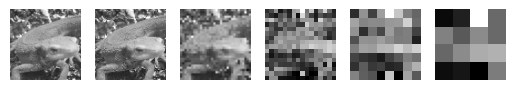

In [5]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

def resize(img, a):
    _h, _w  = img.shape
    h = int(a * _h)
    w = int(a * _w)
    """
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = np.floor(y / a).astype(np.int)
    x = np.floor(x / a).astype(np.int)
    y = np.minimum(y, _h-1)
    x = np.minimum(x, _w-1)
    out = img[y,x]
    """
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / a)
    x = (x / a)

    ix = np.floor(x).astype(int)
    iy = np.floor(y).astype(int)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _w-2)

    dx = x - ix
    dy = y - iy
    #dx = np.repeat(np.expand_dims(dx, axis=-1), 3, axis=-1)
    #dy = np.repeat(np.expand_dims(dy, axis=-1), 3, axis=-1)
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out

pyramid = [gray]
for i in range(1, 6):
    a = 2. ** i
    p = resize(gray, 1. / a)
    pyramid.append(p)

for i in range(6):
    cv2.imwrite("out_{}.jpg".format(2**i), pyramid[i].astype(np.uint8))
    plt.subplot(1, 6, i+1)
    plt.imshow(pyramid[i], cmap='gray')
    plt.axis('off')
    plt.xticks(color="None")
    plt.yticks(color="None")

plt.show()

## Q.76. 顕著性マップ

ここではガウシアンピラミッドを用いた簡単な顕著性マップを作成する。

顕著性マップとは画像の中で人間の目を引きやすい領域を表した画像である。

現在ではディープラーニングによる顕著性マップがよく用いられるが、本来は画像のRGB成分やHSV成分などのガウシアンピラミッドを作成し、それらの差分から求める手法がよく用いられた(例えばIttiらの手法などがある)。

ここではQ.75で作成したガウシアンピラミッドから簡単な顕著性マップを作成する。
アルゴリズムは、
1. ガウシアンピラミッドをそれぞれ、128, 64, 32, ...というサイズになっているが、はじめにそれらを128にリサイズせよ。リサイズはbi-linear補間を用いよ。
2. 作成したピラミッド（それぞれ0, 1, 2, 3, 4, 5と番号をふる）の２つを選び差分を求める。
3. 2で求めた差分を全て足し合わせ、[0, 255]に正規化せよ。

以上で顕著性マップが求められる。
2で選ぶ２つの画像は特に指定はしないが、いいものを選べば解答例のように顕著性マップが作成できる。

イモリの目の部分や色が周辺と極端に違う部分など、人の目に止まりやすい領域が白くなっているのが分かる。

解答例( (0,1), (0,3), (0,5), (1,4), (2,3), (3,5) を使用)

|入力 (imori.jpg) |出力(answers/answer_76.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers/answer_76.jpg)|

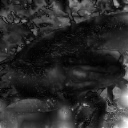

In [6]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

def resize(img, a):
    _h, _w  = img.shape
    h = int(a * _h)
    w = int(a * _w)
    """
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = np.floor(y / a).astype(np.int)
    x = np.floor(x / a).astype(np.int)
    y = np.minimum(y, _h-1)
    x = np.minimum(x, _w-1)
    out = img[y,x]
    """
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / a)
    x = (x / a)

    ix = np.floor(x).astype(int)
    iy = np.floor(y).astype(int)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _w-2)

    dx = x - ix
    dy = y - iy
    #dx = np.repeat(np.expand_dims(dx, axis=-1), 3, axis=-1)
    #dy = np.repeat(np.expand_dims(dy, axis=-1), 3, axis=-1)
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out

pyramid = [gray]
for i in range(1, 6):
    a = 2. ** i
    p = resize(gray, 1. / a)
    p = resize(p, a)
    pyramid.append(p)
    
out = np.zeros((H, W), dtype=np.float32)

out += np.abs(pyramid[0] - pyramid[1])
out += np.abs(pyramid[0] - pyramid[3])
out += np.abs(pyramid[0] - pyramid[5])
out += np.abs(pyramid[1] - pyramid[4])
out += np.abs(pyramid[2] - pyramid[3])
out += np.abs(pyramid[3] - pyramid[5])


out = out / out.max() * 255

out = out.astype(np.uint8)
display(Image.fromarray(out))

## Q.77. ガボールフィルタ

ガボールフィルタを実装せよ。

ガボールフィルタとは

ガウス分布と周波数変換を合わせたフィルタであり、画像の特定方向のみのエッジを抽出する時に使われる。

フィルタは次式で定義される。

```bash
G(y, x) = exp(-(x'^2 + g^2 y'^2) / 2 s^2) * cos(2 pi x' / l + p)
x' = cosA * x + sinA * y
y' = -sinA * x + cosA * y

y, x はフィルタの位置　フィルタサイズがKとすると、 y, x は [-K//2, k//2]　の値を取る。
g ... gamma ガボールフィルタの楕円率
s ... sigma ガウス分布の標準偏差
l ... lambda 周波数の波長
p ... 位相オフセット
A ... フィルタの回転　抽出したい角度を指定する。
```

ここでは、K=111, s=10, g = 1.2, l =10, p=0, A=0としてガボールフィルタを可視化せよ。

ガボールフィルタを実際に使う時は、フィルタ値の絶対値の和が1になるように正規化すると使いやすくなる。

答えでは可視化のためにフィルタの値を[0,255]に正規化している。

|出力(answers/answer_77.jpg)|
|:---:|
|![](answers/answer_77.jpg)|

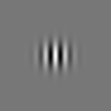

In [7]:
# Gabor
K_size = 111
Sigma = 10
Gamma = 1.2
Lambda = 10.
Psi = 0.
angle = 0

d = K_size // 2

gabor = np.zeros((K_size, K_size), dtype=np.float32)

for y in range(K_size):
    for x in range(K_size):
        px = x - d
        py = y - d
        theta = angle / 180. * np.pi
        _x = np.cos(theta) * px + np.sin(theta) * py
        _y = -np.sin(theta) * px + np.cos(theta) * py
        gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

gabor /= np.sum(np.abs(gabor))

# Visualize
out = gabor - np.min(gabor)
out /= np.max(out)
out *= 255
out = out.astype(np.uint8)
display(Image.fromarray(out))

## Q.78. ガボールフィルタの回転

ここでは A=0, 45, 90, 135として回転方向のガボールフィルタを求めよ。
その他のパラメータはQ.77同様、K=111, s=10, g = 1.2, l =10, p=0とせよ。

ここではガボールフィルタをメソッド化すれば簡単に実装できる。

|出力(answers/answer_78.png)|
|:---:|
|![](answers/answer_78.png)|

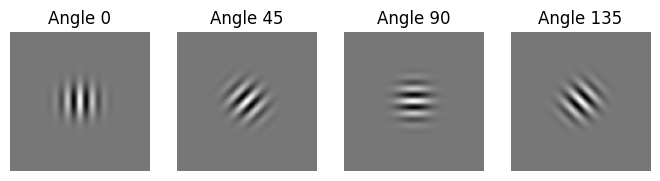

In [8]:
# Gabor

def gabor_f(k=111, s=10, g=1.2, l=10, p=0, A=0):
    d = k // 2

    gabor = np.zeros((k, k), dtype=np.float32)
    
    for y in range(k):
        for x in range(k):
            px = x - d
            py = y - d
            theta = A / 180. * np.pi
            _x = np.cos(theta) * px + np.sin(theta) * py
            _y = -np.sin(theta) * px + np.cos(theta) * py
            gabor[y, x] = np.exp(-(_x**2 + g**2 * _y**2) / (2 * s**2)) * np.cos(2*np.pi*_x/l + p)

    gabor /= np.sum(np.abs(gabor))

    return gabor

As = [0, 45, 90, 135]

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

for i, A in enumerate(As):
    gabor = gabor_f(A=A)
    out = gabor - np.min(gabor)
    out /= np.max(out)
    out *= 255
    out = out.astype(np.uint8)
    plt.subplot(1, 4, i+1)
    plt.imshow(out, cmap='gray')
    plt.axis('off')
    plt.title("Angle "+str(A))

plt.show()

## Q.79. ガボールフィルタによるエッジ抽出

*imori.jpg*をグレースケール化し、A=0, 45, 90, 135 のガボールフィルタでフィルタリングせよ。

パラメータはK=11, s=1.5, g=1.2, l=3, p=0とする。

解答例の様に、ガボールフィルタで指定した方向のエッジが抽出できていることが分かる。
このようにガボールフィルタはエッジの特徴抽出に優れている。

ガボールフィルタは生物の視神経における脳内の一次視覚野(V1)での働きに近いとされていて、つまり生物が見ている時の眼の前の画像の特徴抽出を再現しているともいわれる。

**ディープラーニング**のConvolutional層はガボールフィルタの働きに近いとも考えられている。しかし、ディープラーニングではフィルタの係数が機械学習によって自動的に決定される。機械学習の結果、ガボールフィルタに近い働きが生じると言われる。

入力 (imori.jpg) |出力(answers/answer_79.png)|
|:---:|:---:|
|![](imori.jpg)|![](answers/answer_79.png)|

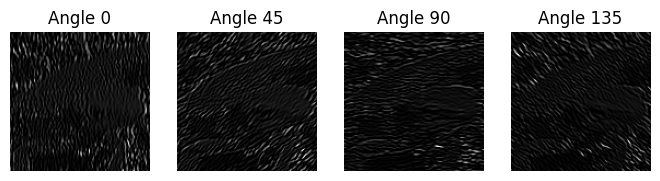

In [9]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Otsu binary
## Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
gray = gray.astype(np.uint8)

# Gabor
def gabor_f(k=111, s=10, g=1.2, l=10, p=0, A=0):
    d = k // 2

    gabor = np.zeros((k, k), dtype=np.float32)
    
    for y in range(k):
        for x in range(k):
            px = x - d
            py = y - d
            theta = A / 180. * np.pi
            _x = np.cos(theta) * px + np.sin(theta) * py
            _y = -np.sin(theta) * px + np.cos(theta) * py
            gabor[y, x] = np.exp(-(_x**2 + g**2 * _y**2) / (2 * s**2)) * np.cos(2*np.pi*_x/l + p)

    gabor /= np.sum(np.abs(gabor))

    return gabor

K_size = 11
Sigma = 1.5
Gamma = 1.2
Lambda = 3.
Psi = 0.

gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

As = [0, 45, 90, 135]

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

for i, A in enumerate(As):
    gabor = gabor_f(k=K_size, s=Sigma, g=Gamma, l=Lambda, p=Psi, A=A)

    out = np.zeros((H, W), dtype=np.float32)
    
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y:y+K_size, x:x+K_size] * gabor)

    out[out < 0] = 0
    out[out > 255] = 255
    
    plt.subplot(1, 4, i+1)
    plt.imshow(out, cmap='gray')
    plt.axis('off')
    plt.title("Angle "+str(A))

plt.show()

## Q.80. ガボールフィルタによる特徴抽出

Q.79で求めた４枚の画像を足し合わせることで、画像の特徴を抽出せよ。

結果を見ると、画像の輪郭部分が白くなっていることからエッジ検出のような出力を得たように見える。

ディープラーニングのCNN(Convolutional Neural Network)では、最初に画像の特徴を抽出する働きが備わっているが、その特徴抽出の計算はこの問で行ったような操作を延々と繰り返している。ディープラーニングではこのようにして画像の特徴を自動的に抽出している。

入力 (imori.jpg) |出力(answers/answer_80.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers/answer_80.jpg)|

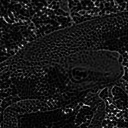

<Figure size 640x480 with 0 Axes>

In [10]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Otsu binary
## Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
gray = gray.astype(np.uint8)

# Gabor
def gabor_f(k=111, s=10, g=1.2, l=10, p=0, A=0):
    d = k // 2

    gabor = np.zeros((k, k), dtype=np.float32)
    
    for y in range(k):
        for x in range(k):
            px = x - d
            py = y - d
            theta = A / 180. * np.pi
            _x = np.cos(theta) * px + np.sin(theta) * py
            _y = -np.sin(theta) * px + np.cos(theta) * py
            gabor[y, x] = np.exp(-(_x**2 + g**2 * _y**2) / (2 * s**2)) * np.cos(2*np.pi*_x/l + p)

    gabor /= np.sum(np.abs(gabor))

    return gabor

K_size = 11
Sigma = 1.5
Gamma = 1.2
Lambda = 3.
Psi = 0.

gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

As = [0, 45, 90, 135]

gs = []

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

for i, A in enumerate(As):
    gabor = gabor_f(k=K_size, s=Sigma, g=Gamma, l=Lambda, p=Psi, A=A)

    out = np.zeros((H, W), dtype=np.float32)
    
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y:y+K_size, x:x+K_size] * gabor)

    out[out < 0] = 0
    out[out > 255] = 255
    
    gs.append(out)


out = np.zeros((H, W), dtype=np.float32)
for g in gs:
    out += g

    
out = out / out.max() * 255
out = out.astype(np.uint8)
display(Image.fromarray(out))